# Capybara or giraffe?

This project is about classification giraffe and capybara images. I decided to use VGG19 model and measure its performance by ROC curve and AUC.

### Loading libraries for dataset loading

In [1]:
import tensorflow as tf
import numpy as np
import os
import imghdr
from matplotlib import pyplot as plt

In [2]:
train_dir = 'train'
os.listdir(train_dir)

['capybara_train', 'giraffe_train']

In [3]:
for animal_class in os.listdir(train_dir):
    for image_name in os.listdir(os.path.join(train_dir, animal_class)):
        image_path = os.path.join(train_dir, animal_class, image_name)
        image_type = imghdr.what(image_path)
        if image_type != 'jpeg':
            print('deleted')
            os.remove(image_path)
            

In [4]:
data = tf.keras.utils.image_dataset_from_directory('train')

Found 1170 files belonging to 2 classes.


In [5]:
data_iterator = data.as_numpy_iterator()

In [6]:
batch = data_iterator.next()

Checking if batches loaded correctly

In [7]:
batch[1]

array([0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 1, 1, 0, 0])

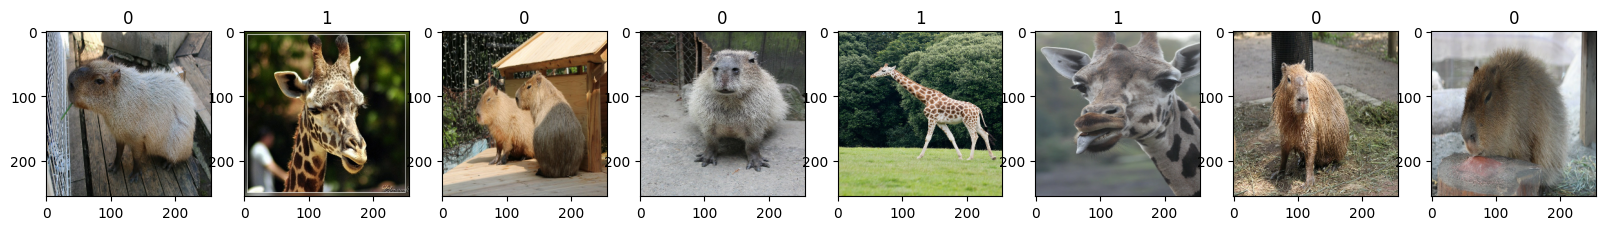

In [8]:
fig, ax = plt.subplots(ncols = 8, figsize = (20, 20))
for idx, img in enumerate(batch[0][:8]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

giraffe = 1
capybara = 0

# Prepocessing data

Now I am using ImageDataGenerator for data augmentation. It produces images of changed photos from original data set. It artificially makes dataset bigger and helps to prevent from overfitting.

In [9]:
from keras.preprocessing.image import ImageDataGenerator

In [10]:
train_data_gen = ImageDataGenerator(rescale=1./255,rotation_range=45, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='constant', cval=125, validation_split=0.2)

In [11]:
val_data_gen = ImageDataGenerator(rescale=1./255)

In [12]:
test_data_gen = ImageDataGenerator(rescale=1./255, )

In [13]:
train_path = 'train'

In [14]:
test_path = 'test'

In [15]:
train_gen = train_data_gen.flow_from_directory(train_path ,batch_size=32, target_size=(256,256), class_mode = 'binary', subset='training')

Found 936 images belonging to 2 classes.


In [16]:
val_gen = train_data_gen.flow_from_directory(train_path, batch_size=32, target_size=(256,256), class_mode = 'binary', subset='validation')

Found 234 images belonging to 2 classes.


In [17]:
test_gen = test_data_gen.flow_from_directory(test_path, batch_size=32, target_size=(256,256), class_mode = 'binary', shuffle=False)
# shuffle = False because it helps to compute correctly roc curve

Found 120 images belonging to 2 classes.


# Model

In [18]:
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.applications.vgg19 import VGG19

In [19]:
vgg19 = VGG19(weights='imagenet',include_top=False,input_shape=(256,256,3))

for layer in vgg19.layers:
    layer.trainable = False
    
model = Sequential()
model.add(vgg19)
model.add(Flatten())
model.add(Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 8, 8, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 1)                 32769     
                                                                 
Total params: 20,057,153
Trainable params: 32,769
Non-trainable params: 20,024,384
_________________________________________________________________


In [20]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [21]:
logdir='logs'

In [22]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

### Model fitting

In [23]:
hist = model.fit(train_gen, epochs=15, validation_data=val_gen, callbacks=[tensorboard_callback])

Epoch 1/15
30/30 [==============================] - 357s 12s/step - loss: 0.5414 - accuracy: 0.7607 - val_loss: 0.2233 - val_accuracy: 0.9359
Epoch 2/15
30/30 [==============================] - 360s 12s/step - loss: 0.1941 - accuracy: 0.9338 - val_loss: 0.1511 - val_accuracy: 0.9487
Epoch 3/15
30/30 [==============================] - 417s 14s/step - loss: 0.1372 - accuracy: 0.9583 - val_loss: 0.1523 - val_accuracy: 0.9274
Epoch 4/15
30/30 [==============================] - 378s 13s/step - loss: 0.1347 - accuracy: 0.9487 - val_loss: 0.1349 - val_accuracy: 0.9658
Epoch 5/15
30/30 [==============================] - 384s 13s/step - loss: 0.1175 - accuracy: 0.9669 - val_loss: 0.1024 - val_accuracy: 0.9615
Epoch 6/15
30/30 [==============================] - 377s 13s/step - loss: 0.0898 - accuracy: 0.9722 - val_loss: 0.1042 - val_accuracy: 0.9615
Epoch 7/15
30/30 [==============================] - 378s 13s/step - loss: 0.0945 - accuracy: 0.9637 - val_loss: 0.1330 - val_accuracy: 0.9444
Epoch 

## Let's visualize loss and accuracy during the trainig

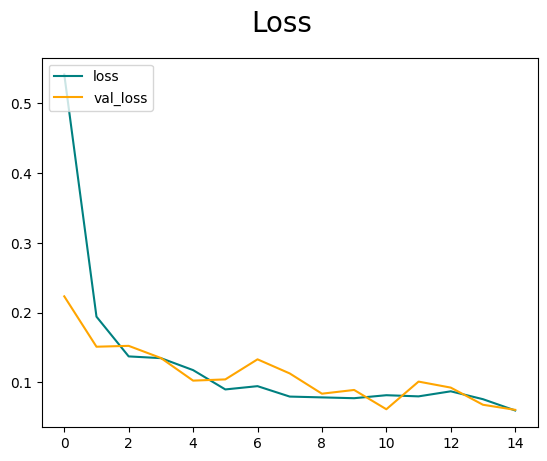

In [24]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

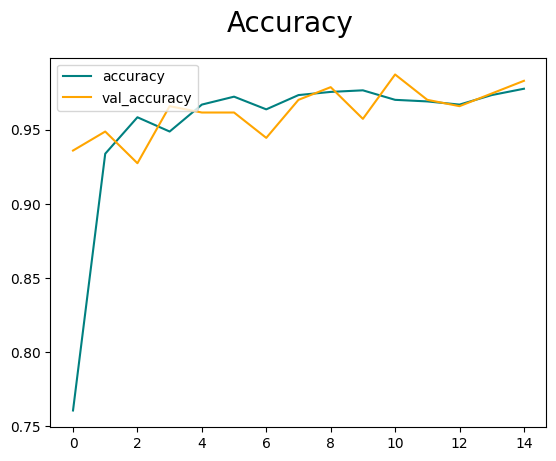

In [25]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

## Let's evaluate our model on test data.

Firstly, I will test my model for each classes seperetly to see how it perfroms on them.

In [26]:
import cv2

In [27]:
def testing (direction, category):
    list = []
    for  image_name in os.listdir(direction):
        img = cv2.imread(os.path.join(direction, image_name))
        resize = tf.image.resize(img, (256,256))
        list.append(model.predict(np.expand_dims(resize/255, 0)))
    zeros = 0
    ones = 0
    accuracy = 0
    for i in range(len(list)):
        if list[i] > 0.5:
            list[i] = 1
            ones = ones + 1
        else:
            list[i] = 0
            zeros = zeros + 1
    if category == 1:
        accuracy = ones/len(list)
    if category == 0:
        accuracy = zeros/len(list)

    print('accuracy = ', accuracy)
    

Testing capybaras photos

In [28]:
testing('capybara_test', 0)

1/1 [==============================] - 0s 340ms/step
accuracy =  1.0


Testing giraffes photos

In [29]:
testing('giraffe_test', 1)

1/1 [==============================] - 0s 319ms/step
accuracy =  0.9868421052631579


It obtained nearly 100% accuracy. But I want to emphasise that <span style="color:red">**it is not ideal**</span> model for sure. Its the matter of my test data and luck. But the result is way better than I expected.

After this result it is easy to work-out how the ROC curve will look like, but let's visualize it and compute AUC value.

In [30]:
from sklearn.metrics import roc_curve, auc

In [31]:
y_pred = model.predict_generator(test_gen)

C:\Users\szyka\AppData\Local\Temp\ipykernel_15972\1093695901.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = model.predict_generator(test_gen)


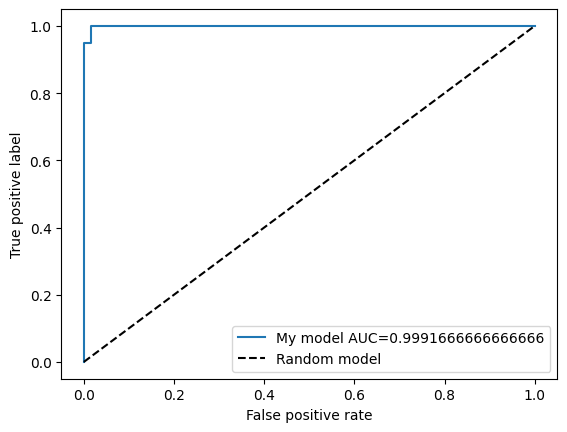

In [42]:
fpr, tpr, thresholds = roc_curve(test_gen.labels, y_pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label = 'My model AUC=' + str(roc_auc))
plt.plot([0, 1], [0, 1], 'k--', label='Random model')
plt.xlabel('False positive rate')
plt.ylabel('True positive label')
plt.legend()
plt.show()


## Now I would like to satisfy my curiosity. During my work on this project I wondered how this model identifies classes.

Firstly, I noticed is that giraffe photos contains savanna grass which looks a lot like a capybara's fur. So I decided to check how model will predict savanna grass images.
Secondly, I was curious whether the model recognize giraffe's coat pattern. I decided to check how model will perform when it comes to images containg this pattern.

In [33]:
def title_val(yhat):
    if yhat < 0.5: 
        return 'Its capybara! val: ' +str(yhat)
    else:
       return 'Its giraffe! val: ' + str(yhat)

1/1 [==============================] - 0s 311ms/step


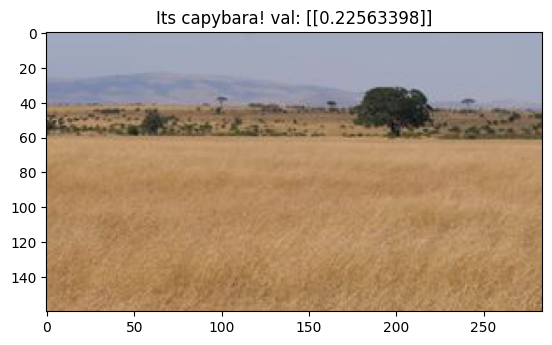

1/1 [==============================] - 0s 280ms/step


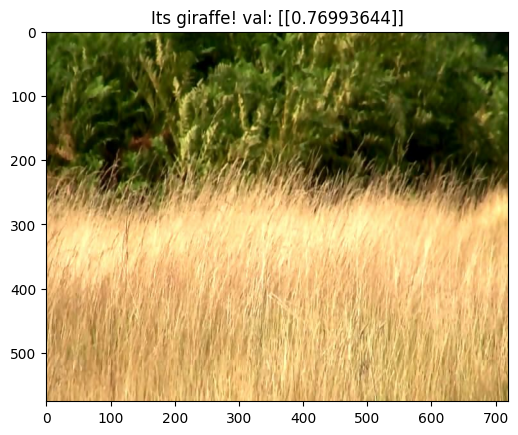

1/1 [==============================] - 0s 262ms/step


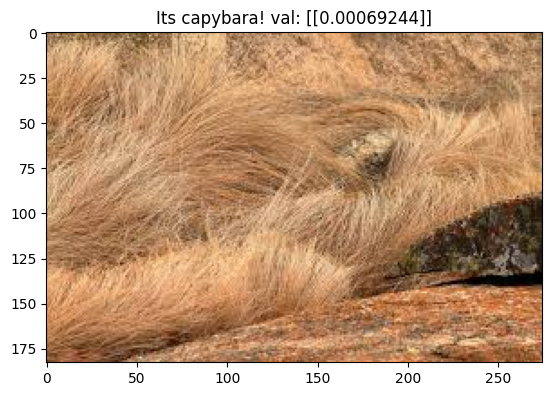

1/1 [==============================] - 0s 269ms/step


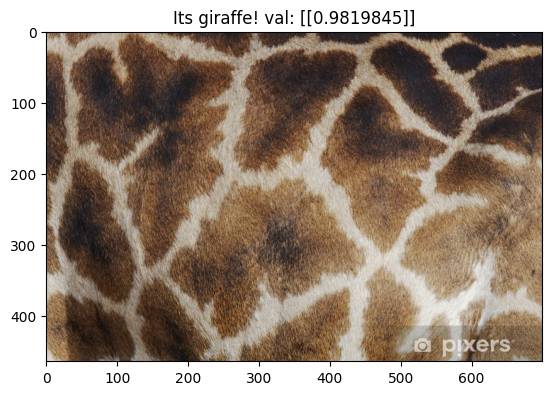

1/1 [==============================] - 0s 270ms/step


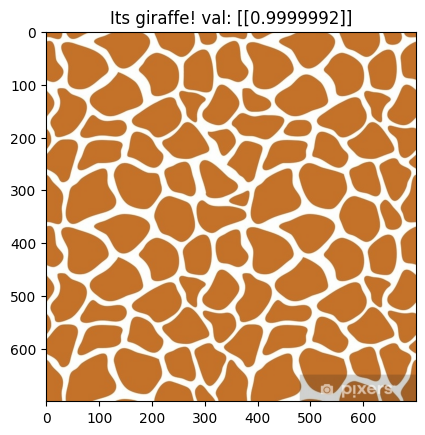

1/1 [==============================] - 0s 272ms/step


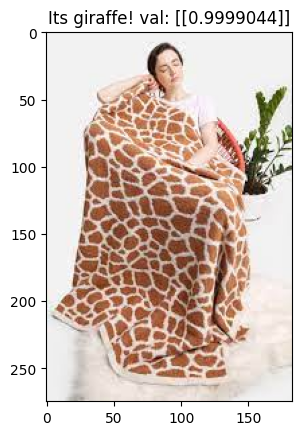

1/1 [==============================] - 0s 276ms/step


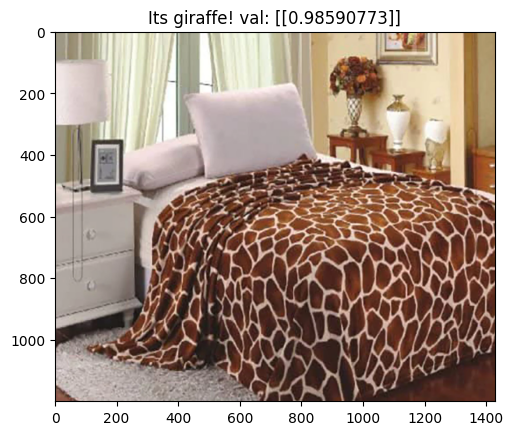

In [34]:
testowanie = 'test_cases'
#fig, axs = plt.subplots(ncols = 5, nrows=4, figsize = (20, 20))
#axs.flatten()
for  image_name in os.listdir(testowanie):
    img = cv2.imread(os.path.join(testowanie, image_name))
    resize = tf.image.resize(img, (256,256))
    result = model.predict(np.expand_dims(resize/255, 0))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title_val(result))
    plt.show()
  

It looks like grass photos are not confusing our model so easily, although the third one is labeled as capybara with high level of certinity. In my opinion third image looks a lot like capybara's fur. But "giraffe pattern" photos are labeled as giraffes. This phenomena are one of the reasons why our <span style="color:red">**model is not perfect**</span>.

## Final test time!

Let's check how our model will classify photo of figurine that my girlfriend gave me for Valentine's Day!

1/1 [==============================] - 0s 260ms/step


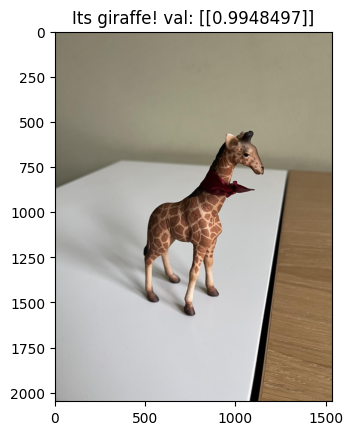

In [35]:
img = cv2.imread('figurine.jpg')
resize = tf.image.resize(img, (256,256))
result = model.predict(np.expand_dims(resize/255, 0))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title(title_val(result))
plt.show()

Success! Model recognized it correctly!

Let's confuse our model. What the model will "say" about this creature?

1/1 [==============================] - 0s 241ms/step


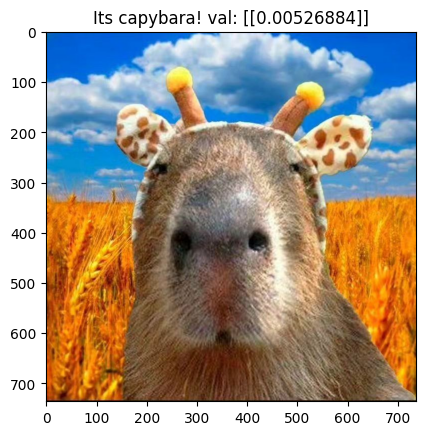

In [36]:
img = cv2.imread('what_is_it.jpg')
resize = tf.image.resize(img, (256,256))
result = model.predict(np.expand_dims(resize/255, 0))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title(title_val(result))
plt.show()

Model decided that it is capybara on the picture. It is not surprising, because vast majority of this "creature" is capybara indeed!

## Summary

Thanks to VGG19 model we obtained very good results on our test data. But, as we can see on examples with giraffe coat pattern, it is not perfect of course. On the other hand it was inevitable, because our model "saw" only photos of capybaras and giraffes. 